# Calculate harmonics of the baroclinic surface velocity

In [3]:
import sys
sys.path.append('/home/mrayson/code/mycurrents')

In [19]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import interp1d, PchipInterpolator
from glob import glob
from datetime import datetime
import re

# from soda.dataio.suntans.sunxray import Sundask, Sunxray
from sfoda.utils.myproj import MyProj
from sfoda.utils.otherplot import axcolorbar
import sfoda.utils.harmonic_analysis as ha
from sfoda.utils.othertime import SecondsSince
from sfoda.utils.barycentric import BarycentricInterp
from sfoda.utils.timeseries import window_index_time
from sfoda.utils.harmonic_analysis import harmonic_fit_array
# from sfoda.suntans.suntides import ap2ep

from sfoda.utils.myproj import MyProj
from sfoda.utils.maptools import plotmap
# from soda.dataio.suntans.suntans_ugrid import ugrid

from mycurrents import oceanmooring as om
from soda.utils.modvsobs import ModVsObs
from sfoda.utils.myairsea import convertUV2SpeedDirn

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

In [5]:
mapfile = '/group/pawsey0106/mrayson/DATA/COAST/GSHHS_shp/i/GSHHS_i_L1.shp'


In [6]:
# !ls /scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs

In [28]:
step = 6301
# step = 6305
# step = 6321

# step += 4
# basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/'
# romsfile = '{}/qck_{}.nc'.format(basedir, step)
basedir = '../ROMSdata/4DVAR_OUT/'
romsfile = '{}/archive_qck_{}.nc'.format(basedir, step)

# basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/verification'
# romsverfile = '{}/qck_ver_{}.nc'.format(basedir, step)
basedir = '../ROMSdata/4DVAR_OUT/'
romsverfile = '{}/archive_qck_ver_{}.nc'.format(basedir, step)
#roms = xr.open_dataset(romsfile, chunks={})

roms = xr.open_dataset(romsfile).isel(ocean_time=range(24,97)) # No dask for a single file

# Load the verification run
romsver = xr.open_dataset(romsverfile).isel(ocean_time=range(24,97)) # No dask for a single file

print(roms.ocean_time[0].values, roms.ocean_time[-1].values,)
roms

2017-04-03T00:00:00.000000000 2017-04-06T00:00:00.000000000


<xarray.Dataset>
Dimensions:          (Nstate: 11, boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 73, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lat_psi          (eta_psi, xi_psi) float64 ...
    lat_rho          (eta_rho, xi_rho) float64 ...
    lat_u            (eta_u, xi_u) float64 ...
    lat_v            (eta_v, xi_v) float64 ...
    lon_psi          (eta_psi, xi_psi) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    lon_u            (eta_u, xi_u) float64 ...
    lon_v            (eta_v, xi_v) float64 ...
  * ocean_time       (ocean_time) datetime64[ns] 2017-04-03 ... 2017-04-06
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
Dimensions without coordinates: Nstate, boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    Akk_bak          float64 ...
    Akp_bak          float64 ...
    Akt_bak          (tracer) float64 ...
    Akv_bak          float64 ...
    Cs_r             (s_rho) float64 ...
    Cs_w             (s_w) float64 ...
    Falpha           float64 ...
    Fbeta            float64 ...
    Fgamma           float64 ...
    GradErr          float64 ...
    Hdecay           (Nstate) float64 ...
    HdecayB          (boundary, Nstate) float64 ...
    HdecayM          (Nstate) float64 ...
    HevecErr         float64 ...
    Hgamma           float64 ...
    HgammaB          float64 ...
    HgammaF          float64 ...
    HgammaM          float64 ...
    LhessianEV       int32 ...
    LhotStart        int32 ...
    Lm2CLM           int32 ...
    Lm3CLM           int32 ...
    LnudgeM2CLM      int32 ...
    LnudgeM3CLM      int32 ...
    LnudgeTCLM       (tracer) int32 ...
    Lobc             (Nstate, boundary) int32 ...
    Lprecond         int32 ...
    Lritz            int32 ...
    LsshCLM          int32 ...
    Lstflux          (tracer) int32 ...
    LtracerCLM       (tracer) int32 ...
    LtracerSponge    (tracer) int32 ...
    LtracerSrc       (tracer) int32 ...
    LuvSponge        int32 ...
    LuvSrc           int32 ...
    LwSrc            int32 ...
    M2nudg           float64 ...
    M3nudg           float64 ...
    Ninner           int32 ...
    Nmethod          int32 ...
    Nouter           int32 ...
    Nrandom          int32 ...
    R0               float64 ...
    Rscheme          int32 ...
    Scoef            float64 ...
    Tcline           float64 ...
    Tcoef            float64 ...
    Tnudg            (tracer) float64 ...
    Vdecay           (Nstate) float64 ...
    VdecayB          (boundary, Nstate) float64 ...
    VdecayM          (Nstate) float64 ...
    Vgamma           float64 ...
    VgammaB          float64 ...
    VgammaM          float64 ...
    Vstretching      int32 ...
    Vtransform       int32 ...
    Znudg            float64 ...
    Zob              float64 ...
    Zos              float64 ...
    ad_Akt_fac       (tracer) float64 ...
    ad_Akv_fac       float64 ...
    ad_tnu2          (tracer) float64 ...
    ad_visc2         float64 ...
    angle            (eta_rho, xi_rho) float64 ...
    dstart           datetime64[ns] ...
    dt               float64 ...
    dtfast           float64 ...
    el               float64 ...
    f                (eta_rho, xi_rho) float64 ...
    gamma2           float64 ...
    grid             int32 ...
    h                (eta_rho, xi_rho) float64 ...
    hc               float64 ...
    mask_psi         (eta_psi, xi_psi) float64 ...
    mask_rho         (eta_rho, xi_rho) float64 ...
    mask_u           (eta_u, xi_u) float64 ...
    mask_v           (eta_v, xi_v) float64 ...
    nADJ             int32 ...
    nAVG             int32 ...
    nHIS             int32 ...
    nOBC             int32 ...
    nRST             int32 ...
    nSFF             int32 ...
    nSTA             int32 ...
  

In [29]:
xroms = roms.lon_rho.values
yroms = roms.lat_rho.values
h = roms.h.values

In [30]:
# Ripped out of SFODA: https://github.com/mrayson/sfoda/blob/master/sfoda/utils/timeseries.py#L1228
def ap2ep(u, v):
    """
    Convert u/v amplitude phase information to tidal ellipses
    
    All angles are in radians
    
    Returns:
        SEMA, SEMI, INC, PHS, ECC
    
    Based on the MATLAB ap2ep function:
        https://www.mathworks.com/matlabcentral/fileexchange/347-tidalellipse/content/ap2ep.m
    """
    # Make complex amplitudes for u and v
    #u = uamp*np.exp(-1j*uphs)
    #v = vamp*np.exp(-1j*vphs)

    #Calculate complex radius of anticlockwise and clockwise circles:
    wp = (u+1j*v)/2.0     # for anticlockwise circles
    wm = np.conj(u-1j*v)/2.0  # for clockwise circles
    # and their amplitudes and angles
    Wp = np.abs(wp)
    Wm = np.abs(wm)
    THETAp = np.angle(wp)
    THETAm = np.angle(wm)
   
    # calculate ep-parameters (ellipse parameters)
    SEMA = Wp+Wm              # Semi  Major Axis, or maximum speed
    SEMI = Wp-Wm            # Semin Minor Axis, or minimum speed
    ECC = SEMI/SEMA          # Eccentricity

    PHA = (THETAm-THETAp)/2.0   # Phase angle, the time (in angle) when 
                               # the velocity reaches the maximum
    INC = (THETAm+THETAp)/2.0   # Inclination, the angle between the 
                               # semi major axis and x-axis (or u-axis).
                               
    return SEMA, SEMI, INC, PHA, ECC

def calc_ubc_ellipse(romsobj, frqnames=['K1','M2']):
    roms = romsobj
    # Calculate the baroclinic velocity
    u_bc = roms['u_sur_eastward'] - roms['ubar_eastward'] 
    v_bc = roms['v_sur_northward'] - roms['vbar_northward'] 
    
    # # Load the data into memory
    # u_bc = u_bc.compute()
    # v_bc = v_bc.compute()
    #u_bc = u_bc
    #v_bc = v_bc
    SEMA, SEMI, INC, PHS, ECC = calc_ubc_ellipse_generic(u_bc.values, v_bc.values, roms['ocean_time'].values, frqnames=frqnames)
    return  SEMA, SEMI, INC, PHS, ECC, u_bc, v_bc
    
def calc_ubc_ellipse_generic(u_bc, v_bc, time, frqnames=['K1','M2']):
    u_bc[np.isnan(u_bc)] = 0.
    v_bc[np.isnan(v_bc)] = 0.
    
    reftime = datetime(2000,1,1)
    # Do the harmonic fits
    frq, names = ha.getTideFreq(frqnames)

    time = SecondsSince(time, basetime=reftime)
    na = 3 # Number of annual harmonics to include
    #aa, Aa, Ba,  = harmonic_fit_dask(u_bc, time, frq)
    Y  = ha.harmonic_fit_array(u_bc, time, frq)
    u0, u_re, u_im = Y[0,...], Y[1::2,...], Y[2::2,...]

    Y  = ha.harmonic_fit_array(v_bc, time, frq)
    v0, v_re, v_im = Y[0,...], Y[1::2,...], Y[2::2,...]
    
    #SEMA, SEMI, INC, PHS, ECC = ap2ep(u_re+1j*u_im, v_re+1j*v_im)
    
    return ap2ep(u_re+1j*u_im, v_re+1j*v_im)


In [31]:
#SEMA, SEMI, INC, PHS, ECC = ap2ep(u_re+1j*u_im, v_re+1j*v_im)
SEMA, SEMI, INC, PHS, ECC, u_bc, v_bc = calc_ubc_ellipse(roms)
SEMA_ver, SEMI_ver, INC_ver, PHS_ver, ECC_ver, u_bc_ver, v_bc_ver = calc_ubc_ellipse(romsver)

/home/mrayson/code/sfoda/sfoda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/mrayson/code/sfoda/sfoda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using t

In [43]:
## WEL Bathy Prelude transect
x0 = 122.753
y0 = -13.1026

x1 = 123.486+0.1
y1 = -13.947-0.1

# Prelude point
xpt = 123.3506
ypt = -13.7641

dx = 0.01 # ~1km

lon = np.arange(x0, x1, dx)
Fx = interp1d([x0,x1],[y0,y1])
lat = Fx(lon)

P = MyProj(None, utmzone=51, isnorth=False)
xx, yy = P.to_xy(lon,lat)

dx = xx[1:]-xx[0:-1]
dy = yy[1:]-yy[0:-1]
dist = np.zeros_like(xx)
dist[1:] = np.abs(dx+1j*dy)
dist = np.cumsum(dist)
dist

array([     0.        ,   1657.37729304,   3314.72180513,   4972.03355866,
         6629.31257601,   8286.55887954,   9943.7724916 ,  11600.95343454,
        13258.10173067,  14915.21740231,  16572.30047176,  18229.35096131,
        19886.36889323,  21543.35428979,  23200.30717323,  24857.22756579,
        26514.11548969,  28170.97096715,  29827.79402035,  31484.58467149,
        33141.34294274,  34798.06885625,  36454.76243418,  38111.42369865,
        39768.05267178,  41424.64937569,  43081.21383246,  44737.74606418,
        46394.24609291,  48050.71394071,  49707.14962961,  51363.55318166,
        53019.92461886,  54676.26396322,  56332.57123673,  57988.84646135,
        59645.08965906,  61301.30085181,  62957.48006152,  64613.62731013,
        66269.74261954,  67925.82601166,  69581.87750836,  71237.89713152,
        72893.88490298,  74549.8408446 ,  76205.76497821,  77861.65732563,
        79517.51790864,  81173.34674906,  82829.14386865,  84484.90928918,
        86140.64303239,  

In [44]:
Fb = BarycentricInterp(np.array([xroms.ravel(), yroms.ravel()]).T, np.array([lon,lat]).T)

SEMA_line_M2 = Fb(SEMA[1,...].ravel())
SEMA_ver_line_M2 = Fb(SEMA_ver[1,...].ravel())

SEMA_line_K1 = Fb(SEMA[0,...].ravel())
SEMA_ver_line_K1 = Fb(SEMA_ver[0,...].ravel())

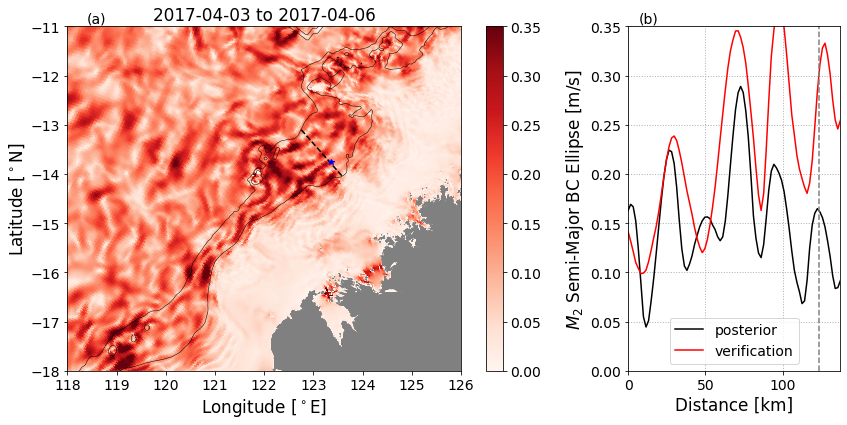

In [45]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1,3), (0,0), colspan=2 )
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.35)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.plot(lon,lat,'k--')
plt.plot(xpt, ypt, 'b*')
plt.xlabel('Longitude [$^\circ$E]')
plt.ylabel('Latitude [$^\circ$N]')
plotmap(mapfile, fieldname=None)
plt.text(0.05,1.01, '(a)', transform=ax1.transAxes)

ax2 = plt.subplot2grid((1,3), (0,2), colspan=1 )
plt.plot(dist/1000, SEMA_line_M2,'k')
plt.plot(dist/1000, SEMA_ver_line_M2,'r')

# plt.plot(lon, SEMA_line_K1,'k:')
# plt.plot(lon, SEMA_ver_line_K1,'r:')
# plt.legend(('ROMS-4DVAR','ROMS'))
plt.legend(('posterior','verification'))

plt.plot([xpt,xpt],[0,0.5],'0.5', ls='--')
plt.ylim(0,0.35)
plt.xlim(dist[0]/1000, dist[-1]/1000)
plt.ylabel('$M_2$ Semi-Major BC Ellipse [m/s]')
plt.xlabel('Distance [km]')
plt.grid(b=True,ls=':',lw=1)
plt.text(0.05,1.01, '(b)', transform=ax2.transAxes)

plt.tight_layout()

# plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_transect_{}_v2.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

In [46]:


# Load the observations for the same point
def load_roms(romsfile, romsvar, zobs):
    roms = om.from_netcdf(romsfile, romsvar)

    # Interpolate ROMS onto observed depths
    Fi = PchipInterpolator(roms.Z, roms.y, axis=0)
    return om.OceanMooring(roms.t, Fi(zobs), zobs)

## Observation loading functions
def load_uv_BRB200(obsvar):
    uvfile = '/home/mrayson/group/mrayson/DATA/FIELD/KISSME/KISSME2017_RDI_QAQC_noerrvel.nc'
    group = 'BRB200_RDI_150_kHz_Quartermaster_16752'

    dso = xr.open_dataset(uvfile, group=group)

    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.zhat.mean(axis=1))
    zobs = -Uobsraw.Z - 10.
    xyin = np.array([dso.Longitude, dso.Latitude])

    return Uobsraw, zobs, xyin

def load_uv_SP250(obsvar):
    uvfile = '../DATA/UWA_KISSME_SP250_fixedheight_uv.nc'

    dso = xr.open_dataset(uvfile)
    dso
    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.depth.values)
    zobs = -Uobsraw.Z
    xyin = np.array([dso.X, dso.Y])
    return Uobsraw, zobs, xyin

def load_uv_ITFTIS(obsvar):
    uvfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_UV.nc'
    dso = xr.open_dataset(uvfile)
    zobs = (-dso['NOMINAL_DEPTH'] + dso['HEIGHT_ABOVE_SENSOR']).values
    Uobsraw = om.OceanMooring(dso.TIME.values, dso[obsvar].values, zobs)
    xyin = np.array([dso.LONGITUDE.values, dso.LATITUDE.values])
    print('dt: ',(dso.TIME.values[1]-dso.TIME.values[0]).astype('timedelta64[s]'))
    return Uobsraw, zobs, xyin

def load_velocity_mo(romsfile,  roms4dvarfile, obsvar, romsvar, t1, t2, loadfunc, resample=True):
    
    Uobsraw, zobs, xyin = loadfunc(obsvar)
    # Load the file w/out DA
    Umod = load_roms(romsfile, romsvar, zobs)
    Umod_da = load_roms(roms4dvarfile, romsvar, zobs)

    dt = (Umod.t[1] - Umod.t[0]).astype('timedelta64[s]').astype(float)

    # #Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
    Uobs = Uobsraw.clip(t1,t2)
    if resample:
        Uobs=Uobs.resample(dt,ndt=1)


    mo_U = ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)

    mo_U_da = ModVsObs(Umod_da.t, Umod_da.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)
    
    return mo_U, mo_U_da

In [47]:
sitename = 'NP250'

roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)

t1,t2 = roms.ocean_time[0].values, roms.ocean_time[-1].values
mydatestr = 'Apr2017'

loadfunc = load_uv_SP250
Uobsraw, zobs, xyin = loadfunc('u')
Uobs = Uobsraw.clip(t1,t2).resample(3600)

Vobsraw, zobs, xyin = loadfunc('v')
Vobs = Vobsraw.clip(t1,t2).resample(3600)

print(Uobs.y.shape, Uobs.Z)
ubar_obs = Uobs.y.mean(axis=0)
ubc_obs = Uobs.y[0,:] - ubar_obs

vbar_obs = Vobs.y.mean(axis=0)
vbc_obs = Vobs.y[0,:] - vbar_obs

SEMA_obs, SEMI_obs, INC_obs, PHS_obs, ECC_obs = calc_ubc_ellipse_generic(ubc_obs, vbc_obs, Uobs.t)
SEMA_obs

(21, 73) [ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170. 180. 190. 200. 210. 220. 230.]


/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/sfoda/sfoda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


masked_array(data=[0.00931110391007402, 0.22812313265252882],
             mask=[False, False],
       fill_value=1e+20)

In [48]:
# Get the point
xroms = roms.lon_rho.values
yroms = roms.lat_rho.values
def get_roms(xpt, ypt, obj):
    dist = np.abs( (xpt-xroms) + 1j*(ypt-yroms))
    idx = np.argwhere(dist==dist.min())
    J,I = idx[0,0],idx[0,1]
    #temp = roms['temp'].isel(eta_rho=J, xi_rho=I).sel(ocean_time=timept, method='nearest')
    temp = obj.isel(eta_rho=J, xi_rho=I)

    #h = roms['h'].isel(eta_rho=J, xi_rho=I)
    #zroms = get_depth(temp.s_rho.values, roms.Cs_r.values[0,:], roms.hc.values[0], h)
    #zroms = get_depth_delayed(temp.s_rho, roms.Cs_r[0,:], roms.hc[0], h[0])

    return temp, J, I #,xr.DataArray(temp, coords={'depth':zroms}, dims=('depth',))

In [49]:
u_bc_site,_,_ = get_roms(xpt, ypt, u_bc)
v_bc_site,_,_ = get_roms(xpt, ypt, v_bc)

u_bc_ver_site,_,_ = get_roms(xpt, ypt, u_bc_ver)
v_bc_ver_site,_,_ = get_roms(xpt, ypt, v_bc_ver)

(array([736422. , 736422.5, 736423. , 736423.5, 736424. , 736424.5,
        736425. ]), <a list of 7 Text xticklabel objects>)

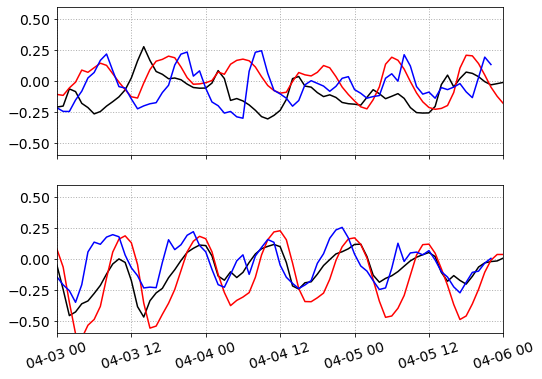

In [50]:
plt.figure(figsize=(8,6))
ax=plt.subplot(211)

plt.plot(u_bc_site.ocean_time, u_bc_site.values,'k')
plt.plot(u_bc_ver_site.ocean_time, u_bc_ver_site.values,'r')

plt.plot(Uobs.t, ubc_obs,'b')
ax.set_xticklabels([])
plt.xlim(t1,t2)
plt.ylim(-.6,0.6)
plt.grid(b=True,ls=':',lw=1)

ax=plt.subplot(212)
plt.plot(v_bc_site.ocean_time, v_bc_site.values,'k')
plt.plot(v_bc_ver_site.ocean_time, v_bc_ver_site.values,'r')
plt.grid(b=True,ls=':',lw=1)

plt.plot(Uobs.t, vbc_obs,'b')
plt.xlim(t1,t2)
plt.ylim(-.6,0.6)
plt.grid(b=True,ls=':',lw=1)

plt.xticks(rotation=17)

(array([736422. , 736422.5, 736423. , 736423.5, 736424. , 736424.5,
        736425. ]), <a list of 7 Text xticklabel objects>)

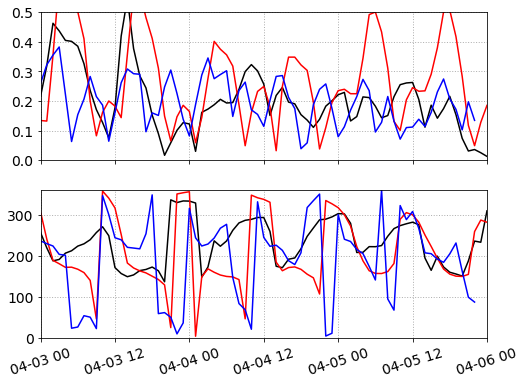

In [51]:
# Convert to speed and direction
dir_site, spd_site = convertUV2SpeedDirn(u_bc_site, v_bc_site)
dir_ver_site, spd_ver_site = convertUV2SpeedDirn(u_bc_ver_site, v_bc_ver_site)

dir_obs, spd_obs = convertUV2SpeedDirn(ubc_obs, vbc_obs)

plt.figure(figsize=(8,6))
ax=plt.subplot(211)

plt.plot(u_bc_site.ocean_time, spd_site,'k')
plt.plot(u_bc_ver_site.ocean_time, spd_ver_site,'r')

plt.plot(Uobs.t, spd_obs,'b')
ax.set_xticklabels([])
plt.xlim(t1,t2)
plt.ylim(0,0.5)
plt.grid(b=True,ls=':',lw=1)

ax=plt.subplot(212)
plt.plot(v_bc_site.ocean_time, dir_site,'k')
plt.plot(v_bc_ver_site.ocean_time, dir_ver_site,'r')
plt.grid(b=True,ls=':',lw=1)

plt.plot(Uobs.t, dir_obs,'b')
plt.xlim(t1,t2)
plt.ylim(0,360)
plt.grid(b=True,ls=':',lw=1)

plt.xticks(rotation=17)

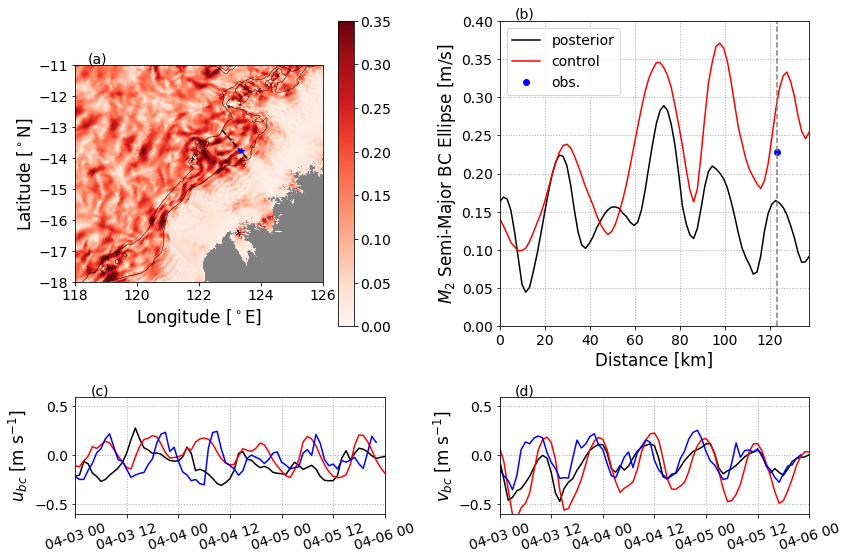

In [54]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((3,4), (0,0), colspan=2,rowspan=2 )
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.35)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
# plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
#          roms.ocean_time[-1].values.astype(str)[0:10])

plt.plot(lon,lat,'k--')
plt.plot(xpt, ypt, 'b*')
plt.xlabel('Longitude [$^\circ$E]')
plt.ylabel('Latitude [$^\circ$N]')
plotmap(mapfile, fieldname=None)
plt.text(0.05,1.01, '(a)', transform=ax1.transAxes)

ax2 = plt.subplot2grid((3,4), (0,2), colspan=2, rowspan=2 )
plt.plot(dist/1000, SEMA_line_M2,'k')
plt.plot(dist/1000, SEMA_ver_line_M2,'r')
plt.plot(xpt, SEMA_obs[1],'bo')
plt.legend(('posterior','control','obs.'))

# plt.plot(lon, SEMA_line_K1,'k:')
# plt.plot(lon, SEMA_ver_line_K1,'r:')
# plt.legend(('ROMS-4DVAR','ROMS'))

plt.plot([xpt,xpt],[0,0.5],'0.5', ls='--')
plt.ylim(0,0.4)
plt.xlim(dist[0]/1000, dist[-1]/1000)
plt.ylabel('$M_2$ Semi-Major BC Ellipse [m/s]')
plt.xlabel('Distance [km]')
plt.grid(b=True,ls=':',lw=1)
plt.text(0.05,1.01, '(b)', transform=ax2.transAxes)

ax3= plt.subplot2grid((3,4), (2,0), colspan=2, rowspan=1 )

plt.plot(u_bc_site.ocean_time, u_bc_site.values,'k')
plt.plot(u_bc_ver_site.ocean_time, u_bc_ver_site.values,'r')

plt.plot(Uobs.t, ubc_obs,'b')
plt.xlim(t1,t2)
plt.ylim(-.6,0.6)
plt.grid(b=True,ls=':',lw=1)
plt.xticks(rotation=17)
plt.text(0.05,1.01, '(c)', transform=ax3.transAxes)
plt.ylabel('$u_{bc}$ [m s$^{-1}$]')

ax4 = plt.subplot2grid((3,4), (2,2), colspan=2, rowspan=1 )
plt.plot(v_bc_site.ocean_time, v_bc_site.values,'k')
plt.plot(v_bc_ver_site.ocean_time, v_bc_ver_site.values,'r')
plt.grid(b=True,ls=':',lw=1)

plt.plot(Uobs.t, vbc_obs,'b')
plt.xlim(t1,t2)
plt.ylim(-.6,0.6)
plt.grid(b=True,ls=':',lw=1)
plt.xticks(rotation=17)
plt.text(0.05,1.01, '(d)', transform=ax4.transAxes)
plt.ylabel('$v_{bc}$ [m s$^{-1}$]')

plt.tight_layout()
plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_transect_{}_v3.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

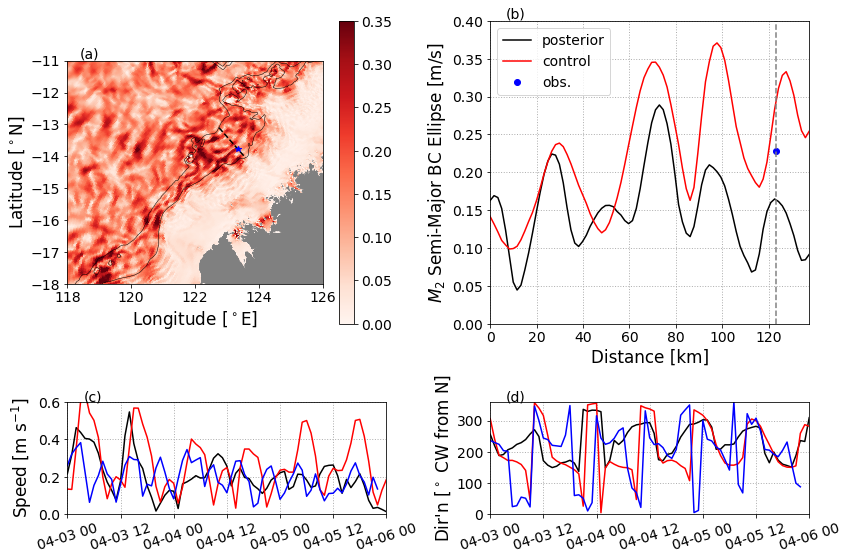

In [56]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((3,4), (0,0), colspan=2,rowspan=2 )
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.35)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
# plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
#          roms.ocean_time[-1].values.astype(str)[0:10])

plt.plot(lon,lat,'k--')
plt.plot(xpt, ypt, 'b*')
plt.xlabel('Longitude [$^\circ$E]')
plt.ylabel('Latitude [$^\circ$N]')
plotmap(mapfile, fieldname=None)
plt.text(0.05,1.01, '(a)', transform=ax1.transAxes)

ax2 = plt.subplot2grid((3,4), (0,2), colspan=2, rowspan=2 )
plt.plot(dist/1000, SEMA_line_M2,'k')
plt.plot(dist/1000, SEMA_ver_line_M2,'r')
plt.plot(xpt, SEMA_obs[1],'bo')
plt.legend(('posterior','control','obs.'))

# plt.plot(lon, SEMA_line_K1,'k:')
# plt.plot(lon, SEMA_ver_line_K1,'r:')
# plt.legend(('ROMS-4DVAR','ROMS'))

plt.plot([xpt,xpt],[0,0.5],'0.5', ls='--')
plt.ylim(0,0.4)
plt.xlim(dist[0]/1000, dist[-1]/1000)
plt.ylabel('$M_2$ Semi-Major BC Ellipse [m/s]')
plt.xlabel('Distance [km]')
plt.grid(b=True,ls=':',lw=1)
plt.text(0.05,1.01, '(b)', transform=ax2.transAxes)

ax3= plt.subplot2grid((3,4), (2,0), colspan=2, rowspan=1 )

plt.plot(u_bc_site.ocean_time, spd_site,'k')
plt.plot(u_bc_ver_site.ocean_time, spd_ver_site,'r')

plt.plot(Uobs.t, spd_obs,'b')
ax.set_xticklabels([])
plt.xlim(t1,t2)
plt.ylim(0,0.6)
plt.grid(b=True,ls=':',lw=1)
plt.xticks(rotation=17)
plt.text(0.05,1.01, '(c)', transform=ax3.transAxes)
plt.ylabel('Speed [m s$^{-1}$]')

ax4 = plt.subplot2grid((3,4), (2,2), colspan=2, rowspan=1 )
plt.plot(v_bc_site.ocean_time, dir_site,'k')
plt.plot(v_bc_ver_site.ocean_time, dir_ver_site,'r')
plt.grid(b=True,ls=':',lw=1)

plt.plot(Uobs.t, dir_obs,'b')
plt.xlim(t1,t2)
plt.ylim(0,360)
plt.grid(b=True,ls=':',lw=1)
plt.xticks(rotation=17)
plt.text(0.05,1.01, '(d)', transform=ax4.transAxes)
plt.ylabel("Dir'n [$^\circ$ CW from N]")

plt.tight_layout()
plt.savefig('../FIGURES/ROMS_4DVAR_BC_Ellipse_transect_{}_v5.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

# Old stuff

In [25]:
def calc_u_ellipse(romsobj, frqnames=['K1','M2']):
    roms = romsobj
    # Calculate the total velocity
    u_bc = roms['u_sur_eastward'] #- roms['ubar_eastward'] 
    v_bc = roms['v_sur_northward'] #- roms['vbar_northward'] 
    
    # # Load the data into memory
    # u_bc = u_bc.compute()
    # v_bc = v_bc.compute()
    u_bc = u_bc.values
    v_bc = v_bc.values
    u_bc[np.isnan(u_bc)] = 0.
    v_bc[np.isnan(v_bc)] = 0.
    
    reftime = datetime(2000,1,1)
    # Do the harmonic fits
    frq, names = ha.getTideFreq(frqnames)

    time = SecondsSince(roms['ocean_time'].values, basetime=reftime)
    na = 3 # Number of annual harmonics to include
    #aa, Aa, Ba,  = harmonic_fit_dask(u_bc, time, frq)
    Y  = ha.harmonic_fit_array(u_bc, time, frq)
    u0, u_re, u_im = Y[0,...], Y[1::2,...], Y[2::2,...]

    Y  = ha.harmonic_fit_array(v_bc, time, frq)
    v0, v_re, v_im = Y[0,...], Y[1::2,...], Y[2::2,...]
    
    #SEMA, SEMI, INC, PHS, ECC = ap2ep(u_re+1j*u_im, v_re+1j*v_im)
    
    return ap2ep(u_re+1j*u_im, v_re+1j*v_im)

In [26]:
SEMA, SEMI, INC, PHS, ECC = calc_u_ellipse(roms)
SEMA_ver, SEMI_ver, INC_ver, PHS_ver, ECC_ver = calc_u_ellipse(romsver)

/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [27]:
Fb = BarycentricInterp(np.array([xroms.ravel(), yroms.ravel()]).T, np.array([lon,lat]).T)

SEMA_line_M2 = Fb(SEMA[1,...].ravel())
SEMA_ver_line_M2 = Fb(SEMA_ver[1,...].ravel())

SEMA_line_K1 = Fb(SEMA[0,...].ravel())
SEMA_ver_line_K1 = Fb(SEMA_ver[0,...].ravel())

NameError: name 'lon' is not defined

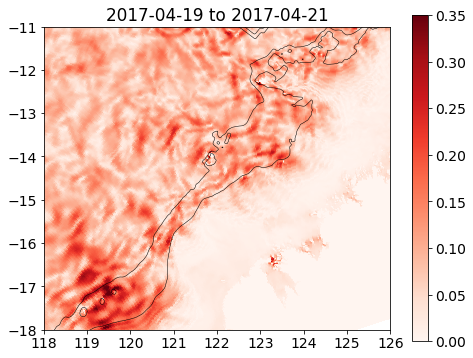

In [16]:
plt.figure(figsize=(12,6))
plt.subplot2grid((1,3), (0,0), colspan=2 )
plt.pcolormesh(xroms, yroms, SEMA[1,...], cmap='Reds', vmax=0.35)
plt.colorbar()
# plt.contour(xroms, yroms, PHS[1,...], [0], colors='k', linewidths=0.2)
plt.contour(xroms, yroms, h, [200,500], colors='k', linewidths=0.5)

plt.xlim(118,126)
plt.ylim(-18.0,-11.0)
plt.gca().set_aspect('equal')
plt.title(roms.ocean_time[0].values.astype(str)[0:10]+' to '+
         roms.ocean_time[-1].values.astype(str)[0:10])

plt.plot(lon,lat,'k--')
plt.plot(xpt, ypt, 'b*')

plt.xlabel('Longitude [$^\circ$E]')
plt.ylabel('Latitude [$^\circ$N]')
plotmap(mapfile, fieldname=None)

plt.subplot2grid((1,3), (0,2), colspan=1 )
plt.plot(lon, SEMA_line_M2,'k')
plt.plot(lon, SEMA_ver_line_M2,'r')

# plt.plot(lon, SEMA_line_K1,'k:')
# plt.plot(lon, SEMA_ver_line_K1,'r:')
# plt.legend(('ROMS-4DVAR','ROMS'))
plt.legend(('posterior','verification'))

plt.plot([xpt,xpt],[0,0.5],'0.5', ls='--')
plt.ylim(0,0.35)
plt.xlim(lon[0], lon[-1])
plt.ylabel('$M_2$ Semi-Major Ellipse [m/s]')
plt.xlabel('Longitude [$^\circ$E]')
plt.grid(b=True,ls=':',lw=1)

plt.tight_layout()

plt.savefig('../FIGURES/ROMS_4DVAR_Ellipse_transect_{}_v2.png'.format(roms.ocean_time[0].values.astype(str)[0:10]), dpi=150)

(-18.0, -11.0)

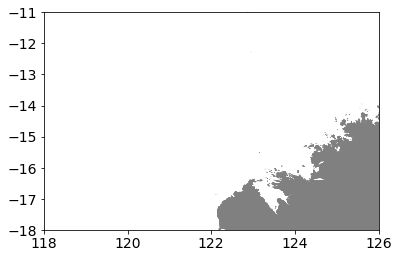

In [37]:
plt.figure()
plotmap(mapfile, fieldname=None)
plt.xlim(118,126)
plt.ylim(-18.0,-11.0)